# Importar las librerias a utilizar

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
#from sklearn.utils import shuffle

from sklearn.tree import DecisionTreeClassifier

In [2]:
# Cargo el dataset en memoria como objeto DataFrame
dataset_route = 'dataset/apple_quality__procesed.csv'

apple_df = pd.read_csv(dataset_route)

# Muestro los 10 primeros registros del dataframe
apple_df.head(10)

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590,1.0
1,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809,1.0
2,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636,0.0
3,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723,1.0
4,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984,1.0
5,-3.425400,-1.409082,-1.913511,-0.555775,-3.853071,1.914616,-2.981523,0.0
6,1.331606,1.635956,0.875974,-1.677798,3.106344,-1.847417,2.414171,1.0
7,-1.995462,-0.428958,1.530644,-0.742972,0.158834,0.974438,-1.470125,1.0
8,-3.867632,-3.734514,0.986429,-1.207655,2.292873,4.080921,-4.871905,0.0
9,-0.727983,-0.442820,-4.092223,0.597513,0.393714,1.620857,2.185608,0.0


Para el modelo de clasificacion, entrenare un Arbol de Decision basado en la clase 'DecisionTreeClassifier'.
Este tipo de modelos es bastante propenso a sufrir sobreajuste, por lo que entrenare varios modelos mediante validacion cruzada, y le asignare a cada uno una amplitud maxima del arbol.

Finalmente, me quedare con el modelo que me arroje un mejor resultado.

In [3]:
# Defino mi matriz de caracteristicas, y mi matriz con los valores de la variable dependiente
X = apple_df.drop(columns = ['Quality'])
y = apple_df['Quality']

X = np.array(X)
y = np.array(y).reshape(-1, 1)

In [4]:
# Divido el conjunto de datos
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

# Desarrollo del modelo

## Entrenamiento con KFold

In [5]:
# Defino una lista con diferentes valores de profundidad que me gustaria probar para el modelo
max_depths = list(range(1, 10))

# Defino una serie de folds a utilizar para entrenar cada modelo con un conjunto de entrenamiento diferente
kf = KFold(n_splits= len(max_depths), shuffle = True, random_state=42)  # Randomizo los ejemplos en cada uno de los folds creados


# Defino una serie de variables iniciales, que me ayuden a ir actualizando el 'mejor modelo' final.
best_model = None               # Esta variable contendra siempre el modelo que me haya entregado un mejor resultado con las diferentes configuraciones de profundidad.
best_depth = None               # Esta variable se actualizara de manera dinamica para almacenar el valor asignado a la profundad del arbol que otorgue mejores resultados.
best_score = -float('inf')      # Inicializo a -infinito la 'mejor puntuacion', y se actualizara de forma dinamica, con el objetivo de quedarme siempre con el mejor modelo.

for max_depth in max_depths:
    scores = []
    for train_index, cv_index in kf.split(X_train):
        
        X_train__, X_cv = X[train_index], X[cv_index]
        y_train__, y_cv = y[train_index], y[cv_index]

        model = DecisionTreeClassifier(max_depth= max_depth)

        # Entreno el modelo
        model.fit(X_train__, y_train__)

        # Obtengo el coeficiente R2 del modelo entrenado con respecto al conjunto de prueba
        score = model.score(X_cv, y_cv)
        scores.append(score)
    
    mean_score = np.mean(scores)
    print(f'Profundidad máx. {max_depth}, Score medio: {mean_score}')

    if score > best_score:
        best_score = score
        best_model = model  # Este modelo es solo representativo, no necesariamente el mejor globalmente
        best_depth = max_depth

        print("Se ha obtenido un mejor arbol que los anteriores:", best_score)

print(f'Mejor profundidad máx.: {best_depth}, Mejor score: {best_score}')


Profundidad máx. 1, Score medio: 0.6053041092999947
Se ha obtenido un mejor arbol que los anteriores: 0.5577464788732395
Profundidad máx. 2, Score medio: 0.6821780872500923
Se ha obtenido un mejor arbol que los anteriores: 0.647887323943662
Profundidad máx. 3, Score medio: 0.6868588560074554
Profundidad máx. 4, Score medio: 0.7368861106715198
Se ha obtenido un mejor arbol que los anteriores: 0.7718309859154929
Profundidad máx. 5, Score medio: 0.7524959997186617
Se ha obtenido un mejor arbol que los anteriores: 0.819718309859155
Profundidad máx. 6, Score medio: 0.7831311213096305
Profundidad máx. 7, Score medio: 0.7978205060575689
Profundidad máx. 8, Score medio: 0.7931379789347823
Profundidad máx. 9, Score medio: 0.800943363049709
Mejor profundidad máx.: 5, Mejor score: 0.819718309859155


Con este enfoque de entrenamiento iterativo, en la que reviso y actualizo la profundidad del arbol en cada iteracion de diferentes modelos, he obtenido un rendimiento final
cercano al 80%. Si bien no esta del todo mal, se esperaria poder obtener un rendimiento mayor.



In [6]:
# Utilizo el mejor modelo para calcular predicciones

y_pred = best_model.predict(X_test)

In [7]:
# Muestro el error cuadratico medio obtenido por el modelo con respecto a los datos de entrenamiento
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)
print("MSE del mejor arbol entrenado por KFold:", mse)

MSE del mejor arbol entrenado por KFold: 0.19


In [8]:
# Represento una matriz de confusion y un cuadro de clasificacion para evaluar el rendimiento del modelo
from sklearn.metrics import confusion_matrix, classification_report

conf_matrix_kfold = confusion_matrix(y_test, y_pred)
print(conf_matrix_kfold)

class_report = classification_report(y_test, y_pred)
print(class_report)

[[343  58]
 [ 94 305]]
              precision    recall  f1-score   support

         0.0       0.78      0.86      0.82       401
         1.0       0.84      0.76      0.80       399

    accuracy                           0.81       800
   macro avg       0.81      0.81      0.81       800
weighted avg       0.81      0.81      0.81       800



## Entrenamiento con GridSearchCV

La clase GridSearch de Scikit permite definir un conjunto de parametros que queremos optimizar al maximo para el conjunto de datos, junto con una lista de posibles valores para 
cada uno.

De esta forma, GridSearchCV se encarga de entrenar el modelo recibido optimizando sus parametros segun aquellos que hemos especificado.

In [9]:
from sklearn.model_selection import GridSearchCV

# Defino un nuevo modelo
model = DecisionTreeClassifier()

# Defino un conjunto de parametros a modificar del Arbol de Decision
parameters = {
    "criterion": ['gini', 'log_loss', 'entropy'],
    "splitter": ['best', 'random'],
    "max_depth": list(range(1, 15)),
    "min_samples_split": list(range(2, 10)),  # Comienzo desde 2 para evitar el error
    "min_samples_leaf": list(range(1, 10)),
}

# Instancio la clase GridSearchCV, pasandole el modelo instanciado, y un conjunto de parametros a modificar
clf = GridSearchCV(model, param_grid = parameters, n_jobs = -1)     # Este entrenamiento es mas demandante, y 'n_jobs = -1' permite usar todos los nucles del procesador para el entrenamiento.
clf.fit(X_train, y_train)   # Entreno el modelo con el subconjunto original de entrenamiento

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'log_loss', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9],
                         'splitter': ['best', 'random']})

In [10]:
# Muestro las metricas del modelo en relacion al conjunto de pruebas

y_pred = clf.predict(X_test)    # Precciones del modelo
mse = mean_squared_error(y_test, y_pred)
r2_score = clf.score(X_test, y_test)


print("MSE del modelo entrenado mediante GridSearchCV:", mse)
print("Puntuacion R2 del modelo entrenado mediante GridSearchCV para el conjunto de prueba:", r2_score)

MSE del modelo entrenado mediante GridSearchCV: 0.175
Puntuacion R2 del modelo entrenado mediante GridSearchCV para el conjunto de prueba: 0.825


In [11]:
# Represento una matriz de confusion y un cuadro de clasificacion para evaluar el rendimiento del modelo
conf_matrix_grid = confusion_matrix(y_test, y_pred)
print(conf_matrix_grid)

class_report = classification_report(y_test, y_pred)
print(class_report)

[[330  71]
 [ 69 330]]
              precision    recall  f1-score   support

         0.0       0.83      0.82      0.82       401
         1.0       0.82      0.83      0.82       399

    accuracy                           0.82       800
   macro avg       0.83      0.83      0.82       800
weighted avg       0.83      0.82      0.82       800



El rendimiento obtenido por el modelo mediante GridSearchCV para optimizacion de hiperparametros es ligeramente superior al obtenido por el entrenamiento mediante KFold, en el que se entrenaban varios modelos con diferentes valores de profundidad.

Sin embargo, si revisamos las predicciones para cada clase de la variable dependiente, vemos que el modelo optimizado por GridSearchCV rinde algo mejor al clasifica ejemplos de manzanas con etiqueta 0 (baja calidad), pero falla mas al clasificar ejemplos de manzanas clasificadas como clase 1 (buena calidad), generando un indice mas elevado de falsos negativos.

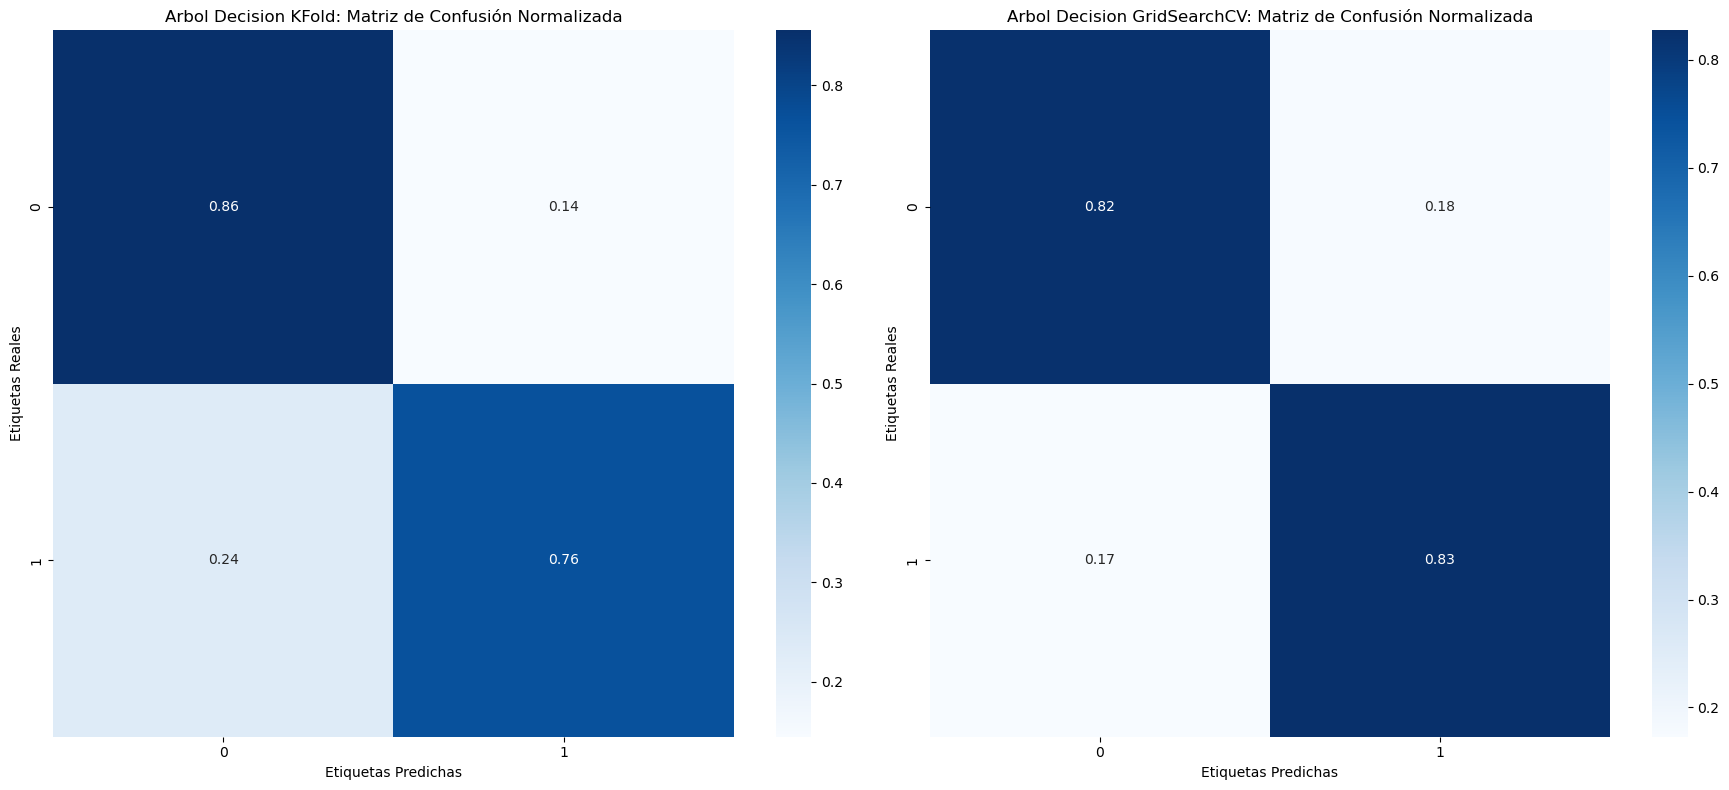

In [14]:
## Comparo los resultados de cada modelo
import matplotlib.pyplot as plt
import seaborn as sns


cm1 = conf_matrix_kfold
cm2 = conf_matrix_grid

# Normalizo las matrices de confusión para obtener frecuencias en lugar de conteos
cm1 = cm1.astype('float') / cm1.sum(axis=1)[:, np.newaxis]
cm2 = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis]

# Grafico las matrices de confusión
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

sns.heatmap(cm1, annot=True, ax=ax[0], cmap='Blues')
ax[0].set_title('Arbol Decision KFold: Matriz de Confusión Normalizada')
ax[0].set_ylabel('Etiquetas Reales')
ax[0].set_xlabel('Etiquetas Predichas')

sns.heatmap(cm2, annot=True, ax=ax[1], cmap='Blues')
ax[1].set_title('Arbol Decision GridSearchCV: Matriz de Confusión Normalizada')
ax[1].set_ylabel('Etiquetas Reales')
ax[1].set_xlabel('Etiquetas Predichas')

plt.tight_layout()
plt.show()